# QUORA - DUPLICATE QUESTION IDENTIFICATION

Quora is visited by more than 95 million visitors each month, so its natural that there are many duplicate questions or questions with similar intent. Due to multiple similar questions visitors have to spend a lot of time to find better answers and also writers have to spend time to answer question with same intent multiple times. The aim of this project is to predict pairs of questions that have similar meaning. In order to solve this problem, natural language processing techniques will be used like TF-IDF, word embeddings and then a
classifier algorithm like XGBoost will be used to classify if question pairs are duplicates or not

In [1]:
import numpy as np
import pandas as pd
import gensim as gn
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from gensim.models.word2vec import Word2Vec
import nltk
from nltk.data import load
#graph polotting library
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine,euclidean
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### LOAD TRAINING AND TEST DATA

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### SAMPLE TRAINING DATA

In [3]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### SAMPLE TEST DATA

In [4]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


#### TOTAL NUMBER OF RECORDS IN TRAINING DATA, TEST DATA AND % OF DUPLICATE PAIRS IN TRAINING DATA

In [5]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Total number of question pairs for test data: {}'.format(len(df_test)))
print('Duplicate pairs : {} %'.format(round(df_train['is_duplicate'].mean()*100,2)))
df_train.is_duplicate.value_counts()

Total number of question pairs for training: 404290
Total number of question pairs for test data: 2345796
Duplicate pairs : 36.92 %


0    255027
1    149263
Name: is_duplicate, dtype: int64

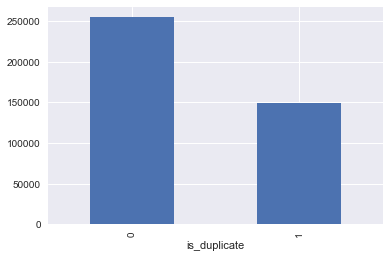

In [6]:
df_train.groupby("is_duplicate")['id'].count().plot.bar()

In [7]:
df_train['question1'][0]

'What is the step by step guide to invest in share market in india?'

In [8]:
df_train['question2'][0]

'What is the step by step guide to invest in share market?'

### DISTRIBUTION OF WORD COUNT IN TRAINING AND TEST DATA

In [9]:
train = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)
dist_train = train.apply(lambda x: len(x.split(' ')))
dist_test = test.apply(lambda x: len(x.split(' ')))

In [10]:
# train is a pandas series object. Displaying first 2 elements of train series 
train[0:2]

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
dtype: object

In [11]:
# dist_train is a pandas series object. Displaying length of first 2 elements of train series 
dist_train[0:2]

0    14
1     8
dtype: int64

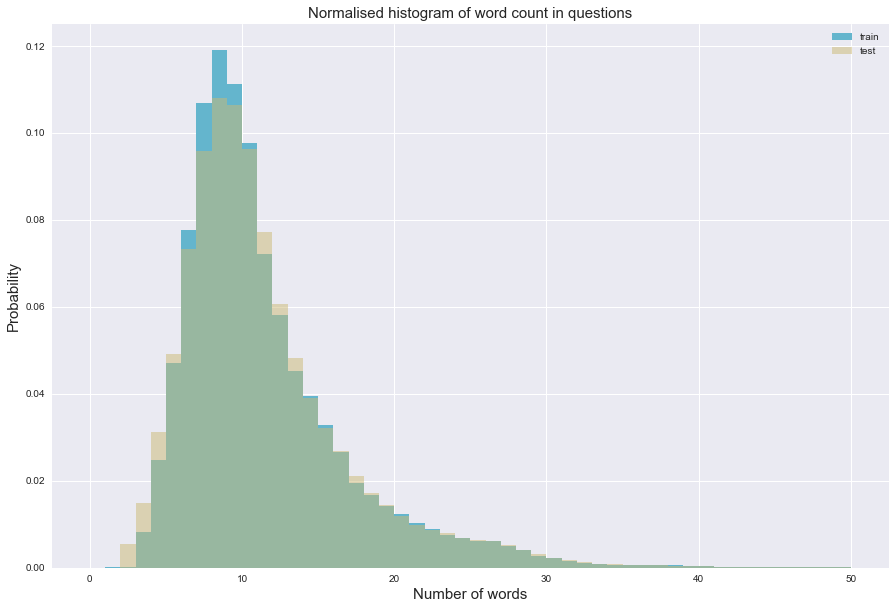

In [12]:
col = sns.color_palette()
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color= col[5], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color= col[4], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### WORDCLOUD PLOT USING WORDCLOUD LIBRARY IN TRAINING DATAFRAME

(-0.5, 1439.5, 1079.5, -0.5)

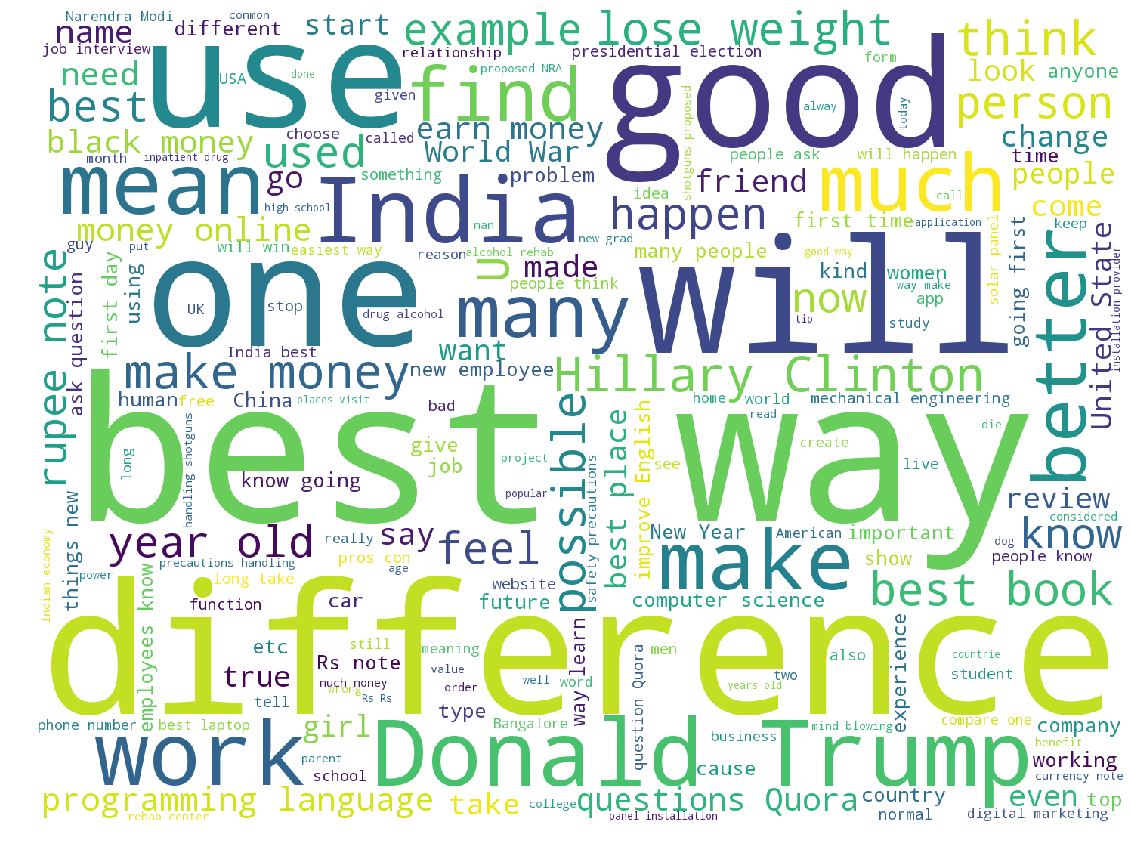

In [16]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080,background_color='white').generate(" ".join(train.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

### TF-IDF (term-frequency-inverse-document-frequency)

In [46]:
from collections import Counter
import scipy.sparse as sparse
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1.0 / (count + eps)

eps = 5000
words = (" ".join(train)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [47]:
first2pairs = {k: weights[k] for k in weights.keys()[:20]}

In [48]:
print first2pairs

{'regularize': 0, 'considered,': 0, "'guess'": 0, 'considered.': 0, 'pieces/rest': 0, 'daiict': 9.997000899730081e-05, '"ipod"?': 0, '(nfl)': 0, 'sunflowers?': 9.996001599360256e-05, 'throwaround': 0, 'telepat.io?': 9.997000899730081e-05, 'considered?': 9.981036031540073e-05, 'woods': 9.982032341784787e-05, 'spiders': 9.921619208254787e-05, 'campari?': 0, 'paiza': 0, 'woody': 9.989012086704625e-05, "'context": 0, 'sunflowers,': 0, 'do/while': 0}


#### Most common words and weights

In [49]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0.0 else 9999)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]


#### Least common words and weights

In [50]:
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

[('chameleons', 9.998000399920016e-05),
 ('275', 9.998000399920016e-05),
 ('276', 9.998000399920016e-05),
 ('kid:', 9.998000399920016e-05),
 ('usenet', 9.998000399920016e-05),
 ('(football', 9.998000399920016e-05),
 ('dittofish?', 9.998000399920016e-05),
 ('sneha', 9.998000399920016e-05),
 ('population)', 9.998000399920016e-05),
 (',delhi', 9.998000399920016e-05)]

In [45]:
df_train=df_train.head(1000)
df_test=df_test.head(1000)

### FEATURE GENERATION - WRITING A FUNCTION (generate_features) to add new columns to df_train

In [46]:
def generate_features(df_train):
    #Number of characters (including spaces) in Question
    df_train['len_q1'] = df_train['question1'].apply(lambda x:len(str(x)))
    df_train['len_q2'] = df_train['question2'].apply(lambda x:len(str(x)))
    
    #Difference in number of characters in q1 and q2
    df_train['diff_len'] = df_train.len_q1-df_train.len_q2
    
    #Number of unique (used 'set' for finding unique) characters in question
    df_train['len_char_q1'] = df_train.question1.apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    df_train['len_char_q2'] = df_train.question2.apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    
    # Number of words in question
    df_train['len_word_q1'] = df_train.question1.apply(lambda x:len(str(x).split()))
    df_train['len_word_q2'] = df_train.question2.apply(lambda x:len(str(x).split()))
    
    #Number of common words in question
    df_train['common_words'] = df_train.apply(lambda x:len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))),axis=1)
    return df_train

In [47]:
df_train = generate_features(df_train)
df_test = generate_features(df_test)
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,10
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,13,4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,10,4


In [48]:
df_train.columns

Index([u'id', u'qid1', u'qid2', u'question1', u'question2', u'is_duplicate',
       u'len_q1', u'len_q2', u'diff_len', u'len_char_q1', u'len_char_q2',
       u'len_word_q1', u'len_word_q2', u'common_words'],
      dtype='object')

In [18]:
df_train.shape

(1000, 14)

### CREATING LDA (Lattent Dirichlet Allocation) features - DOING CLUSTERING ON CORPUS TO GET COMMON TOPICS

In [51]:
# Stemming
import re
p_stemmer = PorterStemmer()
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

# Function to build a corpus
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
    return corpus

In [52]:
data = clean_dataframe(df_train)
corpus = build_corpus(data)
dictionary = corpora.Dictionary(corpus)
corpus = [dictionary.doc2bow(text) for text in corpus]
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=100, id2word = dictionary)

In [53]:
def common_lda_topic(sentence1,sentence2,dictionary,ldamodel,min_proba):
    "find #common topic based on lattent dirichlet allocation model"
    sentence1 = sentence1.split()
    sentence2 = sentence2.split()

    sentence1 = dictionary.doc2bow(sentence1)
    sentence2 = dictionary.doc2bow(sentence2)
    
    topic_a = ldamodel.get_document_topics(sentence1,minimum_probability=min_proba)
    topic_b = ldamodel.get_document_topics(sentence2,minimum_probability=min_proba)
    
    topic_a = list(sorted(topic_a, key=lambda x: x[1]))
    topic_b = list(sorted(topic_b, key=lambda x: x[1]))
    common_topic = set([x[0] for x in topic_a]).intersection(x[0] for x in topic_b)
    return(len(common_topic))

#### ADDING NEW COLUMN 'COMMON_TOPICS' FROM TOPICS GENERATED IN PREVIOUS STEP

In [54]:
df_train['common_topics'] = df_train.apply(lambda x:common_lda_topic(str(x['question1']),str(x['question2']),dictionary,ldamodel,0.1),axis=1)
df_test['common_topics'] = df_test.apply(lambda x:common_lda_topic(str(x['question1']),str(x['question2']),dictionary,ldamodel,0.1),axis=1)

In [55]:
df_train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,common_topics
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,10,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,13,4,0


### CREATING POS-TAGGING FEATURES

In [56]:
def common_pos_tagging(question1,question2):
    question1 = nltk.word_tokenize(question1)
    question2 = nltk.word_tokenize(question2)
    pos_question1 = nltk.pos_tag(question1)
    pos_question2 = nltk.pos_tag(question2)

    pos_1_array = [x[1] for x in pos_question1]
    pos_2_array = [x[1] for x in pos_question2]
    return(len(set(pos_1_array).intersection(pos_2_array)))

In [57]:
def count_distinct_pos_tagging(df_train):
    #Generate all pos-tag null columns
    tagdict = load('help/tagsets/upenn_tagset.pickle')
    pos_tag = tagdict.keys()
    for tag in pos_tag:
        df_train[tag+"_q1"] = 0
        df_train[tag+"_q2"] = 0
        
    for index, row in df_train.iterrows():
        question1 = row.question1.decode('utf-8')
        question1 = nltk.word_tokenize(question1)

        question2 = row.question2.decode('utf-8')
        question2 = nltk.word_tokenize(question2)

        pos_question1 = nltk.pos_tag(question1)
        pos_question1 = [x[1] for x in pos_question1]

        pos_question2 = nltk.pos_tag(question2)
        pos_question2 = [x[1] for x in pos_question2]

        for tag in pos_question1:
            if(tag != "#"):
                df_train.set_value(index,tag+"_q1",row[tag+"_q1"]+1)

        for tag in pos_question2:
            if(tag != "#"):
                df_train.set_value(index,tag+"_q2",row[tag+"_q2"]+1)

In [59]:
df_train['common_pos_count'] = df_train.apply(lambda x:common_pos_tagging(str(x['question1']).decode('utf-8'),str(x['question2']).decode('utf-8')),axis=1)
df_test['common_pos_count'] = df_test.apply(lambda x:common_pos_tagging(str(x['question1']).decode('utf-8'),str(x['question2']).decode('utf-8')),axis=1)
count_distinct_pos_tagging(df_train)
count_distinct_pos_tagging(df_test)

In [60]:
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,...,--_q1,--_q2,JJS_q1,JJS_q2,JJR_q1,JJR_q2,SYM_q1,SYM_q2,UH_q1,UH_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,...,0,0,0,0,0,0,0,0,0,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,...,0,0,0,0,0,0,0,0,0,0


In [40]:
df_train.shape

(1000, 106)

# Word2vec features 
Word2Vec creates a multi-dimensional vector for every word in the english vocabulary (or the corpus it has been trained on). Word2Vec embeddings are very popular in natural language processing and always provide us with great insights. Wikipedia provides a good explanation of what these embeddings are and how they are generated (https://en.wikipedia.org/wiki/Word2vec).

In [32]:
import gensim

In [33]:
#model = gn.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
model.init_sims(replace=True)

In [34]:
print("Word2vec mean of president : {} mean of obama {}".format(model['president'].mean(),model['king'].mean()))

Word2vec mean of president : 0.00630775932223 mean of obama 0.00169826287311


The idea here is to build a vector of each word in differents sentences (question1, question2), each word will be presented in a 300 dimensions vector. So we will try to calculate the average of these vector in order to compare the result obtained in the first and second question. I will calculate differents distances based on theses vectors such as euclidiant distance, cosine similiratity and generate some features based on semantic of words. So, if sentence $s1$ contains $K$ words, we can present this sentence by $K$ arrays of $300$ dimensions. So a matrix of $[K*300]$.

An example of the application of this model is to find the word the most similar to a particular word (semantic sense I mean). Lets try to find the most similar word to `Obama`.

In [35]:
model.most_similar(positive=["dog"])

[(u'dogs', 0.8680490255355835),
 (u'puppy', 0.8106428384780884),
 (u'pit_bull', 0.780396044254303),
 (u'pooch', 0.7627376317977905),
 (u'cat', 0.7609457969665527),
 (u'golden_retriever', 0.7500901818275452),
 (u'German_shepherd', 0.7465174198150635),
 (u'Rottweiler', 0.7437615394592285),
 (u'beagle', 0.7418621778488159),
 (u'pup', 0.7406911253929138)]

In [36]:
def sent2vec(s):
    words = str(s).lower().decode('utf-8')
    words = nltk.word_tokenize(words)
    words = [w for w in words if not w in STOP_WORDS]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    return M

We will take now an example of a sentence and apply the word2vec model of words that contains, Lets take the first observation of the train dataframe. It's `'What is the step by step guide to invest in share market in india?'`, so this sentences contains 7 words (after deleting stop words). So this sentence will be presented by a $[7*300]$ matrix. Let's do that

In [37]:
m = sent2vec(df_train.iloc[0].question1)
print("The sentences vectors {}, the shape of this vector is : {}".format(m,m.shape))

The sentences vectors [[-0.07852414  0.04130891  0.04205321 ...,  0.11536722  0.02307344
  -0.00869906]
 [-0.07852414  0.04130891  0.04205321 ...,  0.11536722  0.02307344
  -0.00869906]
 [ 0.01465341 -0.00877338 -0.0530136  ..., -0.01913343  0.06570699
   0.05861362]
 ..., 
 [-0.02046456 -0.02115659 -0.04092911 ..., -0.03796323 -0.0039545
  -0.08660363]
 [-0.06247045 -0.03513963 -0.09175348 ...,  0.05661384  0.01893635
  -0.00541736]
 [-0.0631949  -0.01935344  0.00284706 ..., -0.02567293 -0.03133414
  -0.03028089]], the shape of this vector is : (7, 300)


The disadvantage of the `word2vec` model that we can't present all the sentence but only words, so we will try some metodologies to present all the sentence using the `word2vec` model, we will for example try to sum the `word2vec` array and calculate the distance between the 2 questions. So each question will be presented using a ${R}^{300}$ vector, and calculate the distance between two ${R}^{300}$ vectors

In [38]:
model.most_similar(positive=["Ryerson"])

[(u'Laurier', 0.6085627675056458),
 (u'Laurentian', 0.6084181070327759),
 (u'Wilfrid_Laurier_University', 0.601338267326355),
 (u'UBC', 0.5960465669631958),
 (u'Lakehead_University', 0.5896972417831421),
 (u'UWO', 0.583482027053833),
 (u'UVic', 0.5814650654792786),
 (u'Fanshawe_College', 0.5784186124801636),
 (u'Guelph', 0.5774319767951965),
 (u'Schulich', 0.5759947299957275)]

### Calculcate differents distances (euclidian, cosine)
We will try now to calculate the distance between two questions. i.e between the two ${R}^{300}$ vector, so we will present these two vector as 2 points in a plan of $300$ dimensions, and calculate the distance between those points. Let's do that

In [42]:
def word2vec_sentences(s):
    M = sent2vec(s)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
# Array contains the word2vec sum (sentences)
question1_vectors = np.zeros((df_train.shape[0], 300))
question2_vectors = np.zeros((df_train.shape[0], 300))

question1_test_vectors = np.zeros((df_train.shape[0], 300))
question2_test_vectors = np.zeros((df_train.shape[0], 300))
for i, q in tqdm(enumerate(df_train.question1.values)):
    question1_vectors[i, :] = word2vec_sentences(q)

for i,q in tqdm(enumerate(df_train.question2.values)):
    question2_vectors[i, :] = word2vec_sentences(q)
    
for i, q in tqdm(enumerate(df_test.question1.values)):
    question1_test_vectors[i, :] = word2vec_sentences(q)

for i,q in tqdm(enumerate(df_test.question2.values)):
    question2_test_vectors[i, :] = word2vec_sentences(q)

In [ ]:
df_train['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
df_train['euclidean_distance'] = [euclidean(x, y) for(x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]

df_test['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]
df_test['euclidean_distance'] = [euclidean(x, y) for(x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]



In [45]:
df_train.euclidean_distance.describe()

count    1000.000000
mean        0.671643
std         0.318388
min         0.000000
25%         0.494646
50%         0.687001
75%         0.877263
max         1.362603
Name: euclidean_distance, dtype: float64

In [46]:
df_train.columns

Index([u'id', u'qid1', u'qid2', u'question1', u'question2', u'is_duplicate',
       u'len_q1', u'len_q2', u'diff_len', u'len_char_q1',
       ...
       u'JJS_q2', u'JJR_q1', u'JJR_q2', u'SYM_q1', u'SYM_q2', u'UH_q1',
       u'UH_q2', u'wmd', u'cosine_distance', u'euclidean_distance'],
      dtype='object', length=109)